# **Имплементация метода Deep Component Analysis через Alternating Direction Neural Networks (ADNN) для решения задачи определения глубины по фотографии**

## Аннотация

В данной работе представлена имплементация метода Deep Component Analysis через Alternating Direction Neural Networks (ADNN), описанного в [1], для решения задачи определения глубины по фотографии. Используя фреймворк PyTorch, разработана базовая модель и модель которая сочетает в себе возможности глубокого обучения и метод ADMM (Alternating Direction Method of Multipliers), обеспечивая эффективную оптимизацию карты глубины.

Основные компоненты моделей включают энкодер на основе модифицированной архитектуры ResNet для извлечения признаков из изображений и декодер, который восстанавливает карту глубины. У модели ADMM реализован итеративный процесс ADMM, который обновляет переменные для достижения сходимости, что позволяет улучшить качество предсказаний.

В ходе экспериментов произведены сравнения работы двух моделей. Произведено сравнение результатов с результатами приведенными в статье.

1. Murdock C., Chang M. F., Lucey S. Deep component analysis via alternating direction neural networks //Proceedings of the European Conference on Computer Vision (ECCV). 2018. P. 820-836.

## Описание задачи

Задача прогнозирования глубины по фото заключается в создании модели, способной предсказывать карту глубины сцены, представленной на изображении. Это важная задача в области компьютерного зрения, имеющая применение в робототехнике, автономных транспортных средствах и дополненной реальности.

Для работы использован датасет: NYU-Depth V2

NYU-Depth V2 — это широко используемый набор данных, содержащий RGB-изображения и соответствующие карты глубины, полученные в различных условиях освещения и обстановке. Датасет включает более 1449 пар изображений и их глубин, снятых в более чем 400 различных сценах.

Что требуется от моделей:

* Извлечение признаков: Разработать модель, которая может эффективно извлекать визуальные признаки из входных RGB-изображений.

* Прогнозирование глубины: Использовать извлеченные признаки для точного предсказания карты глубины, которая соответствует каждому пикселю входного изображения.

* Оценка качества: Оценивать точность модели, используя метрики, такие как среднеквадратичная ошибка (RMSE), Относительная ошибка Relative Error (средняя относительная разница между предсказанными и истинными значениями глубины)
δ1, δ2, δ3 (доли предсказаний, для которых отношение между предсказанным значением и истинным значением находится в пределах определенных порогов).

Подход к решению:

Архитектура моделей:

Энкодер: Использование предварительно обученной сети (например, ResNet) для извлечения признаков.
Декодер: Восстановление пространственной информации для предсказания карты глубины.

Обучение модели:

Настройка гиперпараметров и выбор функции потерь, подходящей для задачи регрессии глубины.
Использование техник регуляризации для улучшения обобщающей способности модели.
Эксперименты и оценка:

Проведение экспериментов на тестовом наборе данных.
Сравнение результатов двух моделей.


## Описание моделей
### Базовая модель
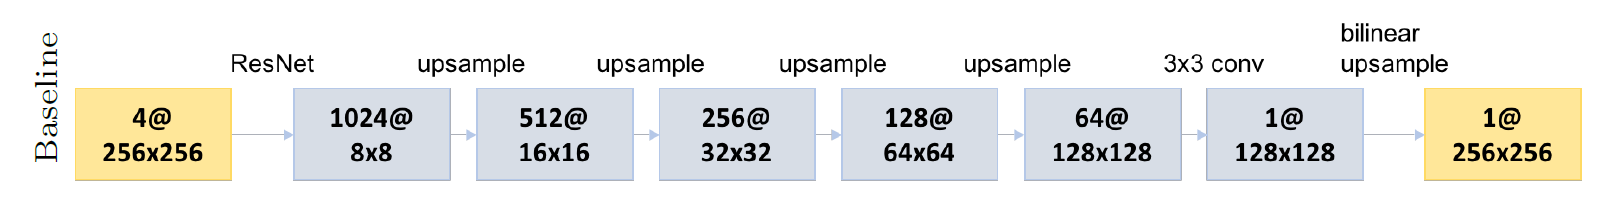
Входной слой:

Эта модель использует ResNet для извлечения признаков и серию операций upsample и свёрток для восстановления карты глубины до исходного разрешения. Модель принимает изображение с 4 каналами размером
256×256. ResNet извлекает признаки, которые затем проходят через серию операций увеличения разрешения и свёрток: от
1024×8×8 до
64×128×128. Затем свёрточный слой преобразует данные до одного канала
128×128. Наконец, билинейная интерполяция увеличивает изображение до
256×256. Архитектура проста и не использует ADMM, что делает её более легкой для обучения и оптимизации.





## Модель ADNN
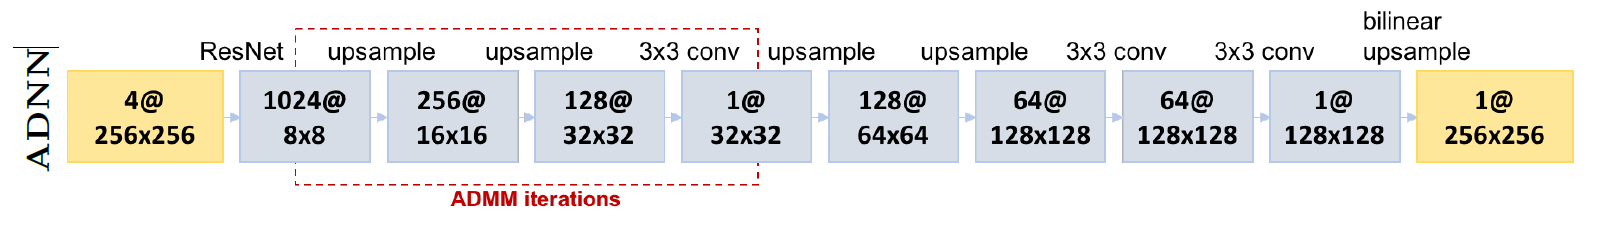

Модель использует ResNet для извлечения признаков. Затем применяется итерация ADMM: начиная с
1024@8×8, увеличивается до
256@16×16 и
128@32×32, далее свёртка
3×3 до
1@32×32. После завершения итерациий ADMM, модель увеличивает до
128@64×64 и
64@128×128. Затем выполняются две свёртки
3×3, сначала до
64@128×128, затем до
1@128×128. В конце билинейная интерполяция увеличивает изображение до
1@256×256.

#### Переменные в контексте ADMM:

Скрытые переменные
* **w**: Это основные параметры модели, которые мы пытаемся оптимизировать. В задачах машинного обучения это могут быть веса нейронной сети.

Вспомогательные переменные
* **z**: Эти переменные вводятся для разделения сложной задачи оптимизации на более простые подзадачи. Они позволяют отдельно рассматривать различные части задачи, облегчая их решение.

Переменные Лагранжа
* **λ**: Они используются для учета ограничений в задаче оптимизации. Эти множители помогают скорректировать решение так, чтобы оно соответствовало заданным ограничениям.

Вместе эти переменные помогают эффективно решать задачи оптимизации, улучшая сходимость и стабильность процесса обучения.

1. **Обновление $(w_j^{t+1})$:**
   $$
   w_j^{t+1} = \arg\min_{w_j} \, L_\rho(w_j, z_{j-1}^{t+1}, z_j^t, \lambda_j^t)
   $$
   Здесь $ L_\rho $ — это расширенная функция Лагранжа, которая включает в себя штрафные члены.

2. **Обновление $z_j^{t+1}$ :**
   $$
   z_j^{t+1} = \arg\min_{z_j} \, L_\rho(w_j^{t+1}, z_{j-1}^{t+1}, z_j, \lambda_j^t)
   $$

3. **Обновление $lambda_j^{t+1}$:**
   $$
   \lambda_j^{t+1} = \lambda_j^t + \rho (w_j^{t+1} - z_j^{t+1})
   $$

Эти шаги выполняются итеративно для достижения сходимости.

ρ — это параметр штрафа или параметр пенализации. Он определяет вес штрафного члена, который контролирует баланс между сходимостью и точностью. Выбор
ρ может влиять на скорость сходимости и качество решения, поэтому его часто подбирают экспериментально.

## Имплементация в Pyton

#### Импорт необходимых библиотек

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
import pandas as pd
import numpy as np
import cv2
import os


 Определим класс **NYUDataset** для работы с набором данных, содержащим изображения и карты глубины.

 Процесс получения данных:

* Чтение путей к файлам из CSV.
Загрузка цветного изображения и карты глубины с помощью OpenCV.
Проверка, удалось ли загрузить файлы. Если нет, выводится сообщение об ошибке.
Преобразование цветного изображения из BGR в RGB.
Изменение размера изображений до
256×256.

* Обработка глубины:

* Масштабирование значений глубины в диапазон 0-255.
* Создание случайной маски, чтобы выбрать 10% значений глубины.
* Применение функции mask_depth, чтобы установить невыбранные значения в 0.

* Объединение каналов:

* Объединение цветного изображения с раскрашенной картой глубины в 4-канальное изображение.

* Трансформации:

Применение заданных трансформаций к цветному изображению и карте глубины, если они указаны.

In [ ]:
class NYUDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        color_path = self.data.iloc[idx, 0]
        depth_path = self.data.iloc[idx, 1]

        color_image_path = os.path.join(self.root_dir, color_path)
        depth_image_path = os.path.join(self.root_dir, depth_path)

        color_image = cv2.imread(color_image_path)
        if color_image is None:
            print(f"Ошибка: Не удалось прочитать файл: {color_image_path}")
            return None, None, None

        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

        depth_image = cv2.imread(depth_image_path, cv2.IMREAD_ANYDEPTH)
        if depth_image is None:
            print(f"Ошибка: Не удалось прочитать файл: {depth_image_path}")
            return None, None, None

        def mask_depth(depth_image, mask):
            masked_depth = depth_image.copy()
            masked_depth[~mask] = 0
            return masked_depth

        # Изменяем размер изображения
        color_image = cv2.resize(color_image, (256, 256))

        # Создаем переменную image
        image = color_image.copy()

        depth_image = cv2.resize(depth_image, (256, 256))

        min_depth = np.min(depth_image)
        max_depth = np.max(depth_image)
        depth_image = (depth_image - min_depth) / (max_depth - min_depth) * 255.0
        depth_image = depth_image.astype(np.uint8)

        mask = np.random.rand(*depth_image.shape) < 0.1
        depth_knw = mask_depth(depth_image, mask)

        color_image = np.concatenate((color_image, depth_knw[:, :, None]), axis=2)

        if self.transform:
            color_image = self.transform(color_image)
            depth_image = self.transform(depth_image)

        return color_image, depth_image, depth_knw, image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка
root_dir = '/content/drive/MyDrive/archive/nyu_data/'
train_dataset = NYUDataset(csv_file=os.path.join(root_dir, 'data', 'nyu2_train.csv'), root_dir=root_dir, train=True, transform=transforms.ToTensor())
test_dataset = NYUDataset(csv_file=os.path.join(root_dir, 'data', 'nyu2_test.csv'), root_dir=root_dir, train=False, transform=transforms.ToTensor())

train_dataset = Subset(train_dataset, range(100)) # этим параметром регулирую количесво загружаемых данных для обучения

Рассмотрим входные изображения (color_image). В качестве 4 канала к изображению добавлено 10% известных сначений глубины (depth_mask). На отображении канал раскрашен цветовой палитрой jeta, в действительности он остаётся черно-белым.

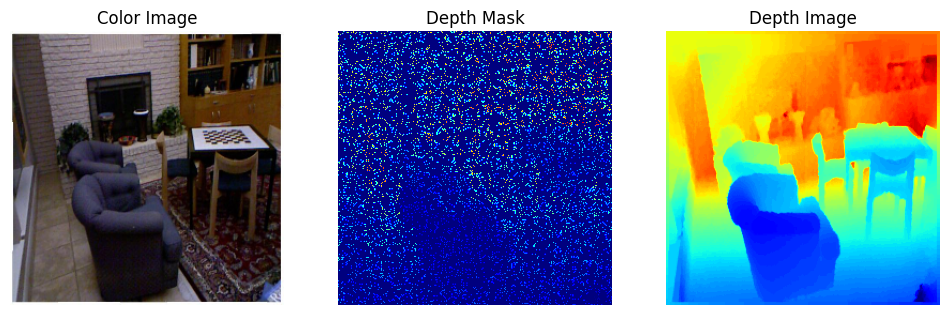

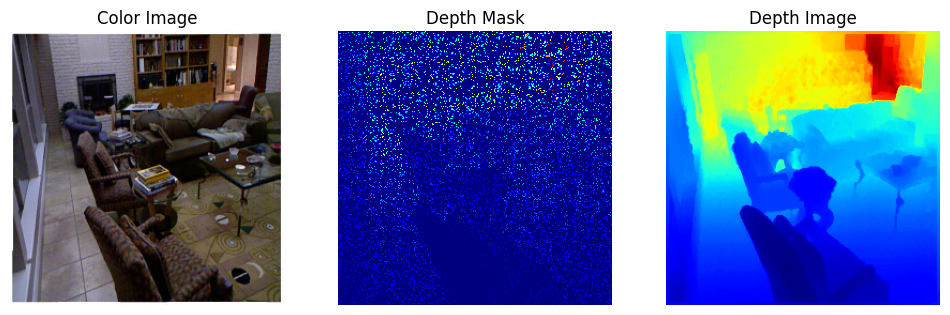

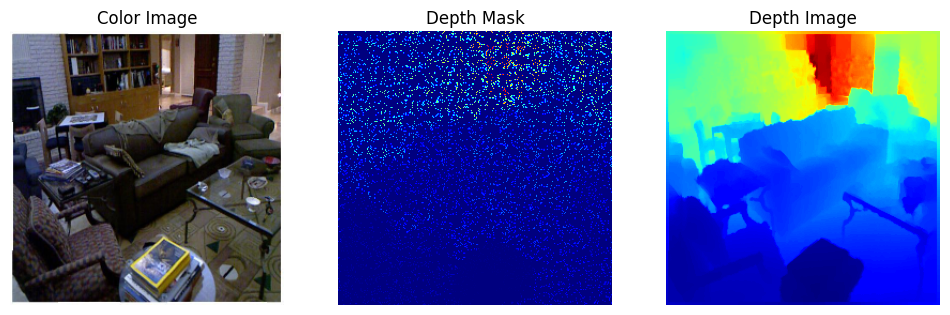

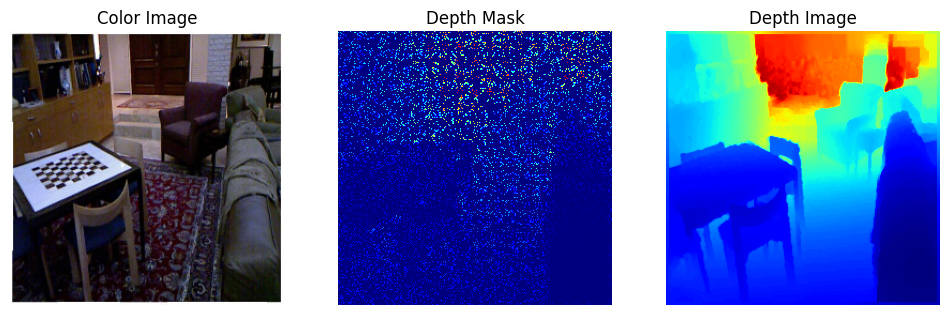

In [ ]:
# Визуализация
def visualize_samples(dataset, num_samples=4):
    for i in range(num_samples):
        color_image, depth_image, depth_knw, image = dataset[i]

        # Преобразуем тензоры обратно в изображения
        color_image = color_image.permute(1, 2, 0).numpy()
        depth_image = depth_image.permute(1, 2, 0).squeeze().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.astype(np.uint8))
        plt.title("Color Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(depth_knw, cmap='jet')
        plt.title("Depth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(depth_image, cmap='jet')
        plt.title("Depth Image")
        plt.axis('off')

        plt.show()

# Визуализация первых 4 образцов
visualize_samples(train_dataset, num_samples=4)

В статье [1] указано, что изображение изменяется до размера 28x28. За счет этого отображение depth_mask выглядит иначе. Однако входное разрешение сети 256x256. Я принял решения не делать эти дополнительные операции на данном этапе.

### Определение класса **ResNetEncoder**

Используется ResNet18 в качестве базовой модели.
Изменяется первый сверточный слой для работы с 4-канальными изображениями (например, RGB + глубина).
Удаляются последние два слоя ResNet18, чтобы использовать только начальные слои для извлечения признаков.
Дополнительные слои:

Добавлены два дополнительных сверточных слоя с активацией ReLU для дальнейшего уменьшения пространственного разрешения и увеличения глубины признаков.
Используется AdaptiveAvgPool2d для получения фиксированного размера выходных признаков 8×8.
Прямой проход (forward):
Изображение проходит через слои ResNet и дополнительные сверточные слои.
Выходной тензор уменьшается до фиксированного размера.


Затем определим класс **DepthNet** для базовой модели.

Создается экземпляр ResNetEncoder для извлечения признаков.
Декодер состоит из последовательности операций Upsample, Conv2d и ReLU для постепенного увеличения пространственного разрешения до исходного размера
256×256.
Декодер:
Последовательно увеличивает размерность признаков, применяя билинейную интерполяцию и свертки.
Завершается выходным слоем, который преобразует признаки в карту глубины с одним каналом.
Прямой проход (forward):

Изображение передается через энкодер для извлечения признаков.
Затем признаки проходят через декодер для восстановления карты глубины.
Назначение
Эта модель предназначена для решения задачи определения глубины по изображению. Она использует энкодер для извлечения признаков из изображения и декодер для преобразования этих признаков в карту глубины.

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, num_channels=4):
        super(ResNetEncoder, self).__init__()

        # Используем ResNet18 без последних слоев
        resnet = models.resnet18(pretrained=False)
        resnet.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.layers = nn.Sequential(*list(resnet.children())[:-2])

        # Дополнительные слои для уменьшения размера
        self.conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

    def forward(self, color_images):
        x = self.layers(color_images)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        output = self.pool(x)

        return output


class DepthNet(nn.Module):
    def __init__(self):
        super(DepthNet, self).__init__()

        # Инициализация ResNetEncoder
        self.encoder = ResNetEncoder()

        # Декодер
        self.decoder = nn.Sequential(
            # [1024, 3, 8, 8]
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  #[1024, 3, 16, 16]
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),  #[512, 3, 16, 16]
            nn.ReLU(),
            # Новый слой Upsample для 512@16x16
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  #[512, 3, 32, 32]
            nn.Conv2d(512, 256, kernel_size=3, padding=1),   #[256, 3, 32, 32]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  #[256, 3, 64, 64]
            nn.Conv2d(256, 128, kernel_size=3, padding=1),      #[128, 3, 64, 64]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  #[128, 3, 128, 128]
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  #[64, 3, 128, 128]
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Final 3x3 convolution [1, 3, 128, 128]
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # [1, 3, 256, 256]
        )

    def forward(self, color_images):
        # ResNet энкодер
        print(color_images.shape)
        features = self.encoder(color_images)
        print(features.shape)
        # Декодер
        output = self.decoder(features)

        return output

In [ ]:
# --- Обучение ---

# 1. Создаем экземпляр модели
model = DepthNet()

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

# Переносим модель на GPU
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Используем устройство: cuda


DepthNet(
  (encoder): ResNetEncoder(
    (layers): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps

In [ ]:
# 2. Определяем функцию потерь и оптимизатор
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 3. Загружаем данные
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
[1,    10] loss: 0.149, rmse: 0.201
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 2

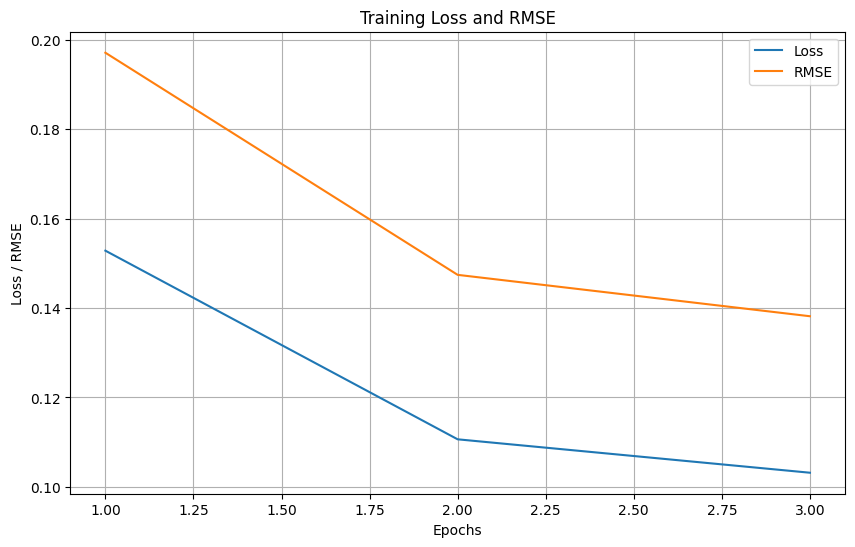

In [ ]:
# Список для хранения значений потерь
losses_per_epoch = []
rmses_per_epoch = []  # Добавляем список для RMSE

# Обучение
for epoch in range(3):
    model.train()
    epoch_loss = 0.0
    epoch_rmse = 0.0  # Добавляем переменную для накопления RMSE в эпохе
    for i, (color_images, depth_images, _, _) in enumerate(train_dataloader):
    # Переносим данные на GPU
        color_images = color_images.to(device)
        depth_images = depth_images.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(color_images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, depth_images)
        epoch_loss += loss.item()  # Накапливаем потери в эпохе

        # Вычисляем RMSE
        rmse = torch.sqrt(torch.mean((outputs - depth_images)**2)).item()
        epoch_rmse += rmse  # Накапливаем RMSE в эпохе

        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()

        # Выводим информацию каждые 10 батчей
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}, rmse: {rmse:.3f}")

    # Выводим информацию об эпохе
    print(f"Эпоха {epoch + 1} завершена")
    losses_per_epoch.append(epoch_loss / len(train_dataloader))
    rmses_per_epoch.append(epoch_rmse / len(train_dataloader))  # Средняя RMSE эпохи

# Сохраняем модель
torch.save(model.state_dict(), "depth_model.pth")

# Строим график потерь и RMSE
epochs = range(1, len(losses_per_epoch) + 1)
plt.figure(figsize=(10, 6))  # Увеличиваем размер фигуры
plt.plot(epochs, losses_per_epoch, label="Loss")
plt.plot(epochs, rmses_per_epoch, label="RMSE")
plt.xlabel("Epochs")
plt.ylabel("Loss / RMSE")
plt.title("Training Loss and RMSE")
plt.grid(True)
plt.legend()
plt.show()

Оценим модель на тестовой выборке

In [ ]:
import torch

epsilon = 1e-6  # Маленькое значение для избежания деления на ноль

# Обновленная функция для вычисления относительной ошибки
def relative_error(pred, true, epsilon=epsilon):
    return torch.mean(torch.abs(pred - true) / (torch.abs(true) + epsilon))

# Оценка модели на тестовой выборке
model.eval()  # Переводим модель в режим оценки

test_loss = 0.0
test_rmse = 0.0

delta1 = 0.0
delta2 = 0.0
delta3 = 0.0

with torch.no_grad():  # Отключаем градиенты для ускорения
    for i, (color_images, depth_images, *_) in enumerate(test_dataloader):
        if i >= 100:  # Ограничиваем количество батчей
            break
        # Переносим данные на устройство
        color_images = color_images.to(device)
        depth_images = depth_images.to(device)

        # Прямой проход
        outputs = model(color_images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, depth_images)
        test_loss += loss.item()

        # Вычисляем RMSE
        rmse = torch.sqrt(torch.mean((outputs - depth_images) ** 2)).item()
        test_rmse += rmse



        # Вычисляем δ метрики
        delta1 += delta_metric(outputs, depth_images, 1.25).item()
        delta2 += delta_metric(outputs, depth_images, 1.25**2).item()
        delta3 += delta_metric(outputs, depth_images, 1.25**3).item()

# Средние значения метрик на тестовой выборке
average_test_loss = test_loss / len(test_dataloader)
average_test_rmse = test_rmse / len(test_dataloader)

average_delta1 = (delta1 / len(test_dataloader)) * 100
average_delta2 = (delta2 / len(test_dataloader)) * 100
average_delta3 = (delta3 / len(test_dataloader)) * 100

print(f"Средняя потеря на тестовой выборке: {average_test_loss:.3f}")
print(f"Средний RMSE на тестовой выборке: {average_test_rmse:.3f}")

print(f"Среднее δ1 на тестовой выборке: {average_delta1:.1f}%")
print(f"Среднее δ2 на тестовой выборке: {average_delta2:.1f}%")
print(f"Среднее δ3 на тестовой выборке: {average_delta3:.1f}%")


torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8])
torch.Size([16, 4, 256, 256])
torch.Size([16, 1024, 8, 8

In [ ]:
# Создаем DataFrame
results = pd.DataFrame({
    'Model': ['Baseline'],
    'Average Test Loss': [average_test_loss],
    'Average Test RMSE': [average_test_rmse],
    'Average δ1 (%)': [average_delta1],
    'Average δ2 (%)': [average_delta2],
    'Average δ3 (%)': [average_delta3],
})
results

,Model,Average Test Loss,Average Test RMSE,Average δ1 (%),Average δ2 (%),Average δ3 (%)
0,Baseline,0.107682,0.141598,50.199704,72.859636,82.793966


<ipython-input-42-d3e0d5897308>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("depth_model.pth"))


torch.Size([1, 4, 256, 256])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 4, 256, 256])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 4, 256, 256])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 4, 256, 256])
torch.Size([1, 1024, 8, 8])


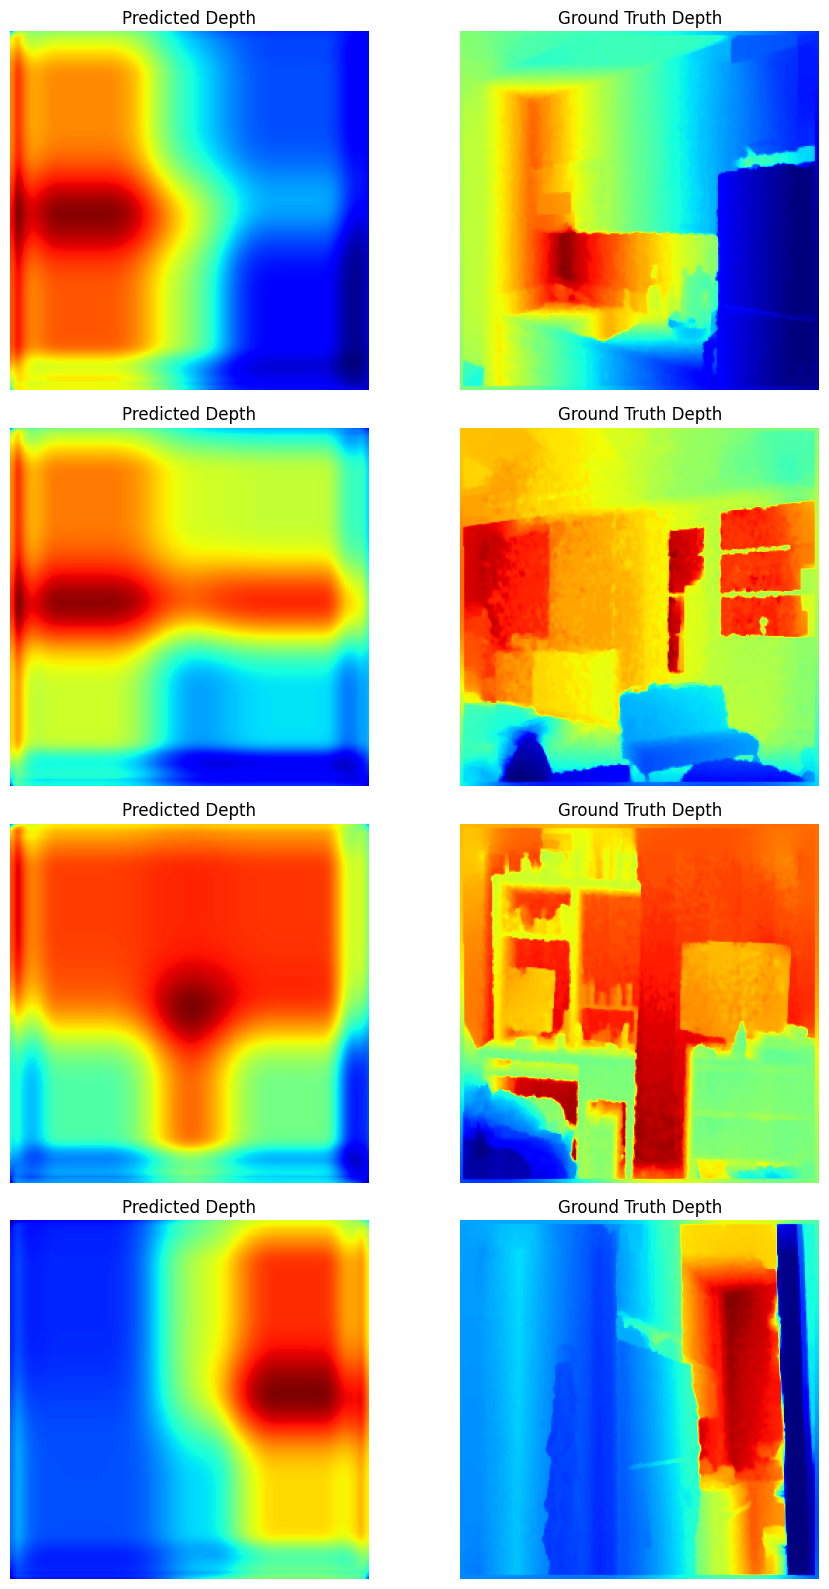

In [ ]:
# Загружаем модель
model.load_state_dict(torch.load("depth_model.pth"))
model.eval()  # Переводим модель в режим оценки

# Отображаем четыре пары изображений
fig, axes = plt.subplots(4, 2, figsize=(10, 16))

for i, data in enumerate(test_dataloader):
    if i >= 4:
        break  # Останавливаемся, когда получим четыре пары

    color_image = data[0][0].to(device)  # Используем первое изображение в батче
    depth_image = data[1][0].cpu()  # Перемещаем целевое изображение на CPU

    # Делаем предсказание
    with torch.no_grad():
        predicted_depth = model(color_image.unsqueeze(0))  # Делаем предсказание

    # Перемещаем данные на CPU и удаляем лишние оси
    predicted_depth = predicted_depth.squeeze().cpu()
    depth_image = depth_image.squeeze()

    # Отображаем изображения side-by-side
    axes[i, 0].imshow(predicted_depth.numpy(), cmap='jet')
    axes[i, 0].set_title("Predicted Depth")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_image.numpy(), cmap='jet')
    axes[i, 1].set_title("Ground Truth Depth")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

Описание результатов обучения базовой модели

### Создание класса **ADNN** для модели с использованием ADNN

In [ ]:
class ADNN(nn.Module):
    def __init__(self, num_cycles=5):
        super(ADNN, self).__init__()
        self.encoder = ResNetEncoder()
        self.num_cycles = num_cycles
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(1024, 256, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(1, 1, kernel_size=3, stride=4, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(1, 1024, kernel_size=1)
        self.relu5 = nn.ReLU()
        self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6 = nn.Conv2d(1, 128, kernel_size=1)
        self.relu6 = nn.ReLU()
        self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu8 = nn.ReLU()
        self.conv9 = nn.Conv2d(64, 1, kernel_size=1)
        self.relu9 = nn.ReLU()
        self.up10 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, color_images):
        features = self.encoder(color_images)
        z = torch.zeros_like(features, requires_grad=True)  #  Инициализируем z с requires_grad=True
        lambda_ = torch.zeros_like(features, requires_grad=True)  # Инициализируем lambda с requires_grad=True
        rho = 1.0

        for i in range(self.num_cycles):
            if i == 0:
                x = features
            else:
                x = output

            x = self.up1(x)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.up2(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.conv3(x)
            x = self.relu3(x)

            if i < self.num_cycles - 1:
                output = self.conv4(x)
                output = self.relu4(output)
                output = self.conv5(output)
                output = self.relu5(output)
            else:
                output = self.up6(x)
                output = self.conv6(output)
                output = self.relu6(output)
                output = self.up7(output)
                output = self.conv7(output)
                output = self.relu7(output)
                output = self.conv8(output)
                output = self.relu8(output)
                output = self.conv9(output)
                output = self.relu9(output)
                output = self.up10(output)

            # Изменяем размер w перед admm_step
            w_resized = torch.nn.functional.interpolate(x, size=(z.size(2), z.size(3)), mode='bilinear', align_corners=True)
            # Передаем w_resized в admm_step
            z, lambda_ = self.admm_step(w_resized, z, lambda_, rho, features)  # Добавили features

        return output, z


    def admm_step(self, w, z, lambda_, rho, features):
        #print(f"w size: {w.size()}, z size: {z.size()}, lambda size: {lambda_.size()}")

        # 1. Обновление w
        w = self.update_w(w, z, lambda_, rho, features)  # Добавили update_w

        # 2. Обновление z
        z = torch.relu((w + lambda_ / rho).requires_grad_())


        # 3. Обновление lambda
        lambda_ = lambda_ + rho * (w - z)

        return z, lambda_

    def update_w(self, w, z, lambda_, rho, features):

        # можно использовать среднеквадратичную ошибку между w и z:
        loss_w = F.mse_loss(w, z)

        # Выполняем шаг градиентного спуска для обновления w
        w = w - 0.01 * torch.autograd.grad(loss_w, w)[0]  # 0.01 - это шаг обучения

        return w

In [ ]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")



Используем устройство: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-35-e8faba2c7179>:95: UserWarning: Using a target size (torch.Size([16, 1024, 8, 8])) that is different to the input size (torch.Size([16, 1, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_w = F.mse_loss(w, z)


[1,    10] loss: 0.069, rmse: 0.263
[1,    20] loss: 0.068, rmse: 0.260
[1,    30] loss: 0.061, rmse: 0.247
[1,    40] loss: 0.075, rmse: 0.275
[1,    50] loss: 0.069, rmse: 0.263
[1,    60] loss: 0.065, rmse: 0.255


<ipython-input-35-e8faba2c7179>:95: UserWarning: Using a target size (torch.Size([8, 1024, 8, 8])) that is different to the input size (torch.Size([8, 1, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_w = F.mse_loss(w, z)


Эпоха 1 завершена


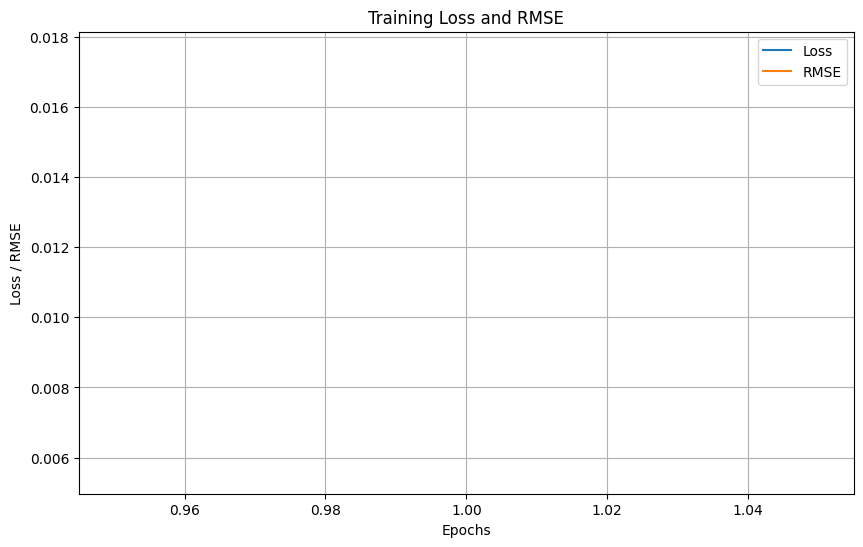

In [ ]:
def train(model, train_dataloader, optimizer, criterion, device):
    """
    Функция обучения модели.
    """
    model.train()
    epoch_loss = 0.0
    epoch_rmse = 0.0
    for i, (color_images, depth_images, _, _) in enumerate(train_dataloader):
        # Переносим данные на GPU
        color_images = color_images.to(device)
        depth_images = depth_images.to(device)

        # Обнуляем градиенты оптимизатора
        optimizer.zero_grad()

        # Прямой проход
        outputs, _ = model(color_images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, depth_images)
        epoch_loss += loss.item()

        # Вычисляем RMSE
        rmse = torch.sqrt(torch.mean((outputs - depth_images)**2)).item()
        epoch_rmse += rmse

        # Обратный проход и обновление весов
        loss.backward()
        optimizer.step()

        # Выводим информацию каждые 10 батчей
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}, rmse: {rmse:.3f}")

    # Вычисляем среднюю потерю и RMSE за эпоху
    epoch_loss /= len(train_dataloader.dataset)
    epoch_rmse /= len(train_dataloader.dataset)

    return epoch_loss, epoch_rmse

# Загрузка данных (здесь добавьте свой код для загрузки данных)
# ...

# Создание экземпляра модели ADNN
model = ADNN().to(device)

# Создание оптимизатора
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Создание функции потерь (например, MSE)
criterion = nn.MSELoss()

# Запуск обучения
losses_per_epoch = []
rmses_per_epoch = []
for epoch in range(1):
    epoch_loss, epoch_rmse = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Эпоха {epoch + 1} завершена")
    losses_per_epoch.append(epoch_loss)
    rmses_per_epoch.append(epoch_rmse)

# Сохраняем модель
torch.save(model.state_dict(), "depth_model.pth")

# Строим график потерь и RMSE
epochs = range(1, len(losses_per_epoch) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_per_epoch, label="Loss")
plt.plot(epochs, rmses_per_epoch, label="RMSE")
plt.xlabel("Epochs")
plt.ylabel("Loss / RMSE")
plt.title("Training Loss and RMSE")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
epsilon = 1e-6  # Маленькое значение для избежания деления на ноль

# Обновленная функция для вычисления относительной ошибки
def relative_error(pred, true, epsilon=epsilon):
    return torch.mean(torch.abs(pred - true) / (torch.abs(true) + epsilon))

# Оценка модели на тестовой выборке
model.eval()  # Переводим модель в режим оценки

test_loss = 0.0
test_rmse = 0.0

delta1 = 0.0
delta2 = 0.0
delta3 = 0.0

with torch.no_grad():  # Отключаем градиенты для ускорения
    for i, (color_images, depth_images, *_) in enumerate(test_dataloader):
        if i >= 100:  # Ограничиваем количество батчей
            break
        # Переносим данные на устройство
        color_images = color_images.to(device)
        depth_images = depth_images.to(device)

        # Прямой проход
        outputs = model(color_images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, depth_images)
        test_loss += loss.item()

        # Вычисляем RMSE
        rmse = torch.sqrt(torch.mean((outputs - depth_images) ** 2)).item()
        test_rmse += rmse

        # Вычисляем δ метрики
        delta1 += delta_metric(outputs, depth_images, 1.25).item()
        delta2 += delta_metric(outputs, depth_images, 1.25**2).item()
        delta3 += delta_metric(outputs, depth_images, 1.25**3).item()

# Средние значения метрик на тестовой выборке
average_test_loss = test_loss / len(test_dataloader)
average_test_rmse = test_rmse / len(test_dataloader)

average_delta1 = (delta1 / len(test_dataloader)) * 100
average_delta2 = (delta2 / len(test_dataloader)) * 100
average_delta3 = (delta3 / len(test_dataloader)) * 100

print(f"Средняя потеря на тестовой выборке: {average_test_loss:.3f}")
print(f"Средний RMSE на тестовой выборке: {average_test_rmse:.3f}")

print(f"Среднее δ1 на тестовой выборке: {average_delta1:.1f}%")
print(f"Среднее δ2 на тестовой выборке: {average_delta2:.1f}%")
print(f"Среднее δ3 на тестовой выборке: {average_delta3:.1f}%")

def delta_metric(pred, true, threshold):
    with torch.no_grad():
        diff = torch.abs(pred - true)  # Абсолютная разница
        delta = (diff > threshold).float().mean()  # Среднее значение логических значений (1 для True, 0 для False)
        return delta * 100  # Возвращаем процент

<ipython-input-35-e8faba2c7179>:95: UserWarning: Using a target size (torch.Size([16, 1024, 8, 8])) that is different to the input size (torch.Size([16, 1, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_w = F.mse_loss(w, z)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
epsilon = 1e-6  # Маленькое значение для избежания деления на ноль

# Обновленная функция для вычисления относительной ошибки
def relative_error(pred, true, epsilon=epsilon):
    return torch.mean(torch.abs(pred - true) / (torch.abs(true) + epsilon))

# Оценка модели на тестовой выборке
model.eval()  # Переводим модель в режим оценки

test_loss = 0.0
test_rmse = 0.0

delta1 = 0.0
delta2 = 0.0
delta3 = 0.0

with torch.no_grad():  # Отключаем градиенты для ускорения
    for i, (color_images, depth_images, *_) in enumerate(test_dataloader):
        if i >= 100:  # Ограничиваем количество батчей
            break
        # Переносим данные на устройство
        color_images = color_images.to(device)
        depth_images = depth_images.to(device)

        # Прямой проход
        outputs = model(color_images)

        # Вычисляем функцию потерь
        loss = criterion(outputs, depth_images)
        test_loss += loss.item()

        # Вычисляем RMSE
        rmse = torch.sqrt(torch.mean((outputs - depth_images) ** 2)).item()
        test_rmse += rmse



        # Вычисляем δ метрики
        delta1 += delta_metric(outputs, depth_images, 1.25).item()
        delta2 += delta_metric(outputs, depth_images, 1.25**2).item()
        delta3 += delta_metric(outputs, depth_images, 1.25**3).item()

# Средние значения метрик на тестовой выборке
average_test_loss = test_loss / len(test_dataloader)
average_test_rmse = test_rmse / len(test_dataloader)

average_delta1 = (delta1 / len(test_dataloader)) * 100
average_delta2 = (delta2 / len(test_dataloader)) * 100
average_delta3 = (delta3 / len(test_dataloader)) * 100

print(f"Средняя потеря на тестовой выборке: {average_test_loss:.3f}")
print(f"Средний RMSE на тестовой выборке: {average_test_rmse:.3f}")

print(f"Среднее δ1 на тестовой выборке: {average_delta1:.1f}%")
print(f"Среднее δ2 на тестовой выборке: {average_delta2:.1f}%")
print(f"Среднее δ3 на тестовой выборке: {average_delta3:.1f}%")

<ipython-input-29-510fe093b680>:94: UserWarning: Using a target size (torch.Size([16, 1024, 8, 8])) that is different to the input size (torch.Size([16, 1, 8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_w = F.mse_loss(w, z)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn